## Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

    1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
    2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных 
    определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
    3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

Приступим.
Первым делом подгрузим имеющиемся данные, посмотрим описательные характеристики, проведем предобработку, проверим, присутствуют ли пропущенные значения в данных, поменяем типы данных, если это необходимо.

In [2]:
reg = pd.read_csv(r'shared/problem1-reg_data.csv', sep = ';')
auth = pd.read_csv(r'shared/problem1-auth_data.csv', sep = ';')

In [3]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit = 's').dt.round('d')

In [6]:
reg.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,2000-01-14,3
3,2000-05-29,4
4,2000-09-16,5


In [7]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


In [8]:
reg.reg_ts.describe()

count                 1000000
unique                   5111
top       2020-09-23 00:00:00
freq                     1643
first     1998-11-18 00:00:00
last      2020-09-24 00:00:00
Name: reg_ts, dtype: object

In [9]:
reg.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [10]:
reg.uid.duplicated().sum()

0

In [11]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [12]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [13]:
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit = 's').dt.round('d')

In [14]:
auth.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,1999-07-26,2
3,1999-07-31,2
4,1999-08-06,2


In [15]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


In [16]:
auth.auth_ts.describe()

count                 9601013
unique                   6168
top       2020-09-21 00:00:00
freq                    16037
first     1998-11-18 00:00:00
last      2020-09-24 00:00:00
Name: auth_ts, dtype: object

In [17]:
auth.isnull().sum()

auth_ts    0
uid        0
dtype: int64

In [18]:
auth.duplicated().sum()

0

В ходе предварительного анализа выявлено, что нулевых значений и дубликатов в данных нет, данные приведены к нужным типам.
\
Временной интервал предоставленных данных -- 18.11.1998 - 24.09.2020.

Займемся написанием функции для подсчета retention игроков по дням в течении заданного временного промежутка.
\
Также в функции пропишем визуализацию хитмэпом для наглядности представления результатов.

In [19]:
def retention_count(registrations, autorizations, start_date, interval):
    '''
    Функция, вычисляющая показатель retention в течении заданного временного промежутка
    # registrations - файл с данными о регистрации пользователей
    # autorizations - файл с данными об авторизации пользователей
    # start_date  - дата первого дня для расчета retention
    # interval - промежуток, для которого считаем retention
    
    '''
    
    start_date = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    finish_date = (pd.to_datetime(start_date) + pd.Timedelta(days = interval)).strftime('%Y-%m-%d')
    
    # Мерджим входные файлы по номеру пользователя
    reg_auth = autorizations.merge(registrations, on = 'uid')
    
    # Создадим колонку "lifetime" для удобства, которая будет нам показывать, 
    # сколько для каждого из дней покупок было совершено в следующий день
    reg_auth['lifetime'] = ((reg_auth['auth_ts'] - reg_auth['reg_ts']) / np.timedelta64(1, 'D')).round().astype(int)
    
    # Оставляем данные только с необходимым для анализа интервалом
    period = reg_auth[(reg_auth['reg_ts'] >= start_date) \
                      & (reg_auth['auth_ts'] <= finish_date) \
                      & (reg_auth['lifetime'] <= interval)]
    
    # Группируем данные по дате регистрации и дням с момента регистрации, считаем количество уникальных пользователей
    cohort = period.groupby(['reg_ts', 'lifetime'])['uid'].apply(pd.Series.nunique).reset_index()
    
    # Считаем retention и выводим его в отдельную таблицу
    retention = cohort.pivot_table(index = 'reg_ts', columns = 'lifetime', values = 'uid')
    retention = retention.divide(retention.iloc[:,0], axis = 0).fillna(0).round(3)
    
    # Визуализируем данные
    plt.figure(figsize = (20, 15))
    plt.title('Retention Rate since {} within {} days'.format(start_date, interval), fontsize = 30)
    ax = sns.heatmap(retention, annot = True, fmt = '0.1%', vmax = 0.2, linewidths = 1, linecolor = 'black', cmap = "Greens")
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 0.05, 0.1, 0.15, 0.2])
    cbar.set_ticklabels(['0%', '5%', '10%', '15%', '20%'])
    
    return retention

Для примера расчитаем показатель retention в промежутке в 30 дней начиная с 1 января 2018 года.

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.0,0.009,0.034,0.050,0.056,0.059,0.059,0.050,0.038,0.056,...,0.034,0.047,0.016,0.031,0.022,0.025,0.031,0.025,0.041,0.025
2018-01-02,1.0,0.025,0.038,0.047,0.059,0.066,0.053,0.031,0.034,0.069,...,0.044,0.047,0.012,0.031,0.025,0.034,0.031,0.019,0.031,0.000
2018-01-03,1.0,0.019,0.038,0.062,0.062,0.069,0.062,0.050,0.044,0.072,...,0.050,0.038,0.028,0.034,0.025,0.019,0.041,0.041,0.000,0.000
2018-01-04,1.0,0.009,0.059,0.053,0.075,0.062,0.059,0.075,0.040,0.050,...,0.040,0.031,0.053,0.044,0.034,0.022,0.025,0.000,0.000,0.000
2018-01-05,1.0,0.025,0.050,0.056,0.028,0.059,0.062,0.081,0.053,0.059,...,0.062,0.044,0.028,0.037,0.047,0.044,0.000,0.000,0.000,0.000
2018-01-06,1.0,0.031,0.047,0.040,0.034,0.065,0.096,0.056,0.037,0.053,...,0.034,0.022,0.062,0.019,0.037,0.000,0.000,0.000,0.000,0.000
2018-01-07,1.0,0.022,0.043,0.059,0.056,0.056,0.068,0.080,0.040,0.071,...,0.065,0.028,0.028,0.050,0.000,0.000,0.000,0.000,0.000,0.000
2018-01-08,1.0,0.031,0.046,0.062,0.040,0.050,0.059,0.068,0.053,0.053,...,0.040,0.046,0.025,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-01-09,1.0,0.043,0.037,0.056,0.052,0.080,0.068,0.037,0.056,0.059,...,0.049,0.046,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


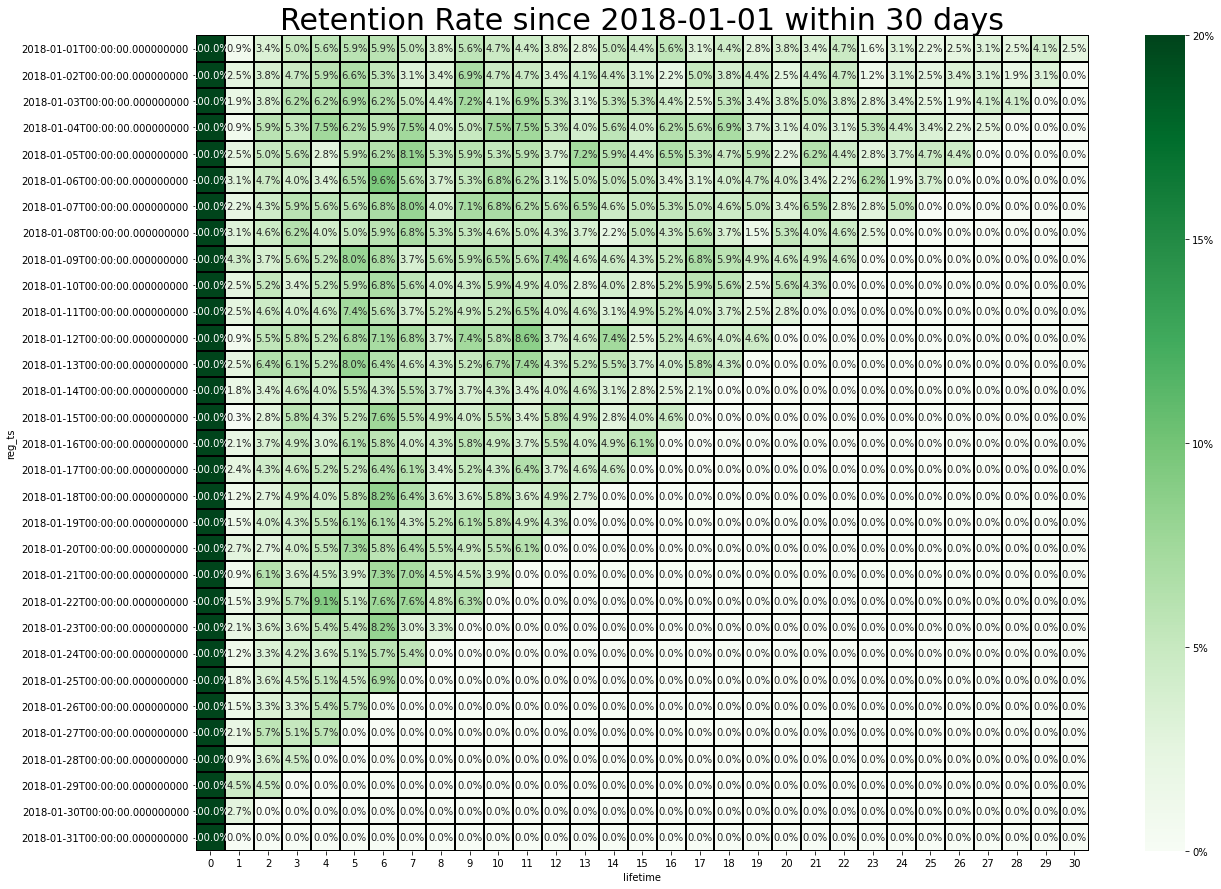

In [20]:
retention_count(reg, auth, '2018-01-01', 30)







## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [21]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
import pylab

from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Приступим.
Первым делом подгрузим имеющиемся данные, посмотрим описательные характеристики, проведем предобработку, проверим, присутствуют ли пропущенные значения в данных, поменяем типы данных, если это необходимо.

In [22]:
AB = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep=';') 

In [23]:
AB.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [24]:
AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [25]:
AB.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [26]:
AB.duplicated().sum()

0

Видим, что с данными все в порядке. Также видим, что в колонке testgroup - 2 типа (группы).

Проверим условия задачи. Проверим, что число пользователей и число платящих пользователей - как в условии.
\
И таким образом определим, какая из групп a и b является тестовой, а какая контрольной. 
\
Также проверим условие превышения показателя ARPU одной группой над другой в 5 процентов.

In [27]:
# Кол-во игроков в группе a
AB.query('testgroup == "a"').shape[0]

202103

In [28]:
# Кол-во платящих игроков в группе a 
AB.query('testgroup == "a" and revenue > 0').shape[0]  

1928

In [29]:
# Кол-во игроков в группе b
AB.query('testgroup == "b"').shape[0]

202667

In [30]:
# Кол-во платящих игроков в группе b
AB.query('testgroup == "b" and revenue > 0').shape[0]  

1805

Таким образом, группа a является контрольной. Группа b является тестовой.

In [31]:
# Считаем ARPU для групп
AB.groupby('testgroup', as_index=False) \
    .agg({'revenue': 'mean'}) \
    .round(2) \
    .rename(columns={"revenue": "ARPU"})

,testgroup,ARPU
0,a,25.41
1,b,26.75


In [32]:
diff_ARPU = ((26.75 - 25.41) / 26.75) * 100

In [33]:
diff_ARPU

5.009345794392523

Видим, что действительно значение ARPU в тестовой группе на 5 % выше, чем в контрольной.

Проведем небольшой предварительный анализ для каждой из групп с учетом рассмотрения только платящих пользователей.

In [34]:
a = AB.query('testgroup == "a" and revenue > 0')
b = AB.query('testgroup == "b" and revenue > 0')

In [35]:
a.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [36]:
b.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


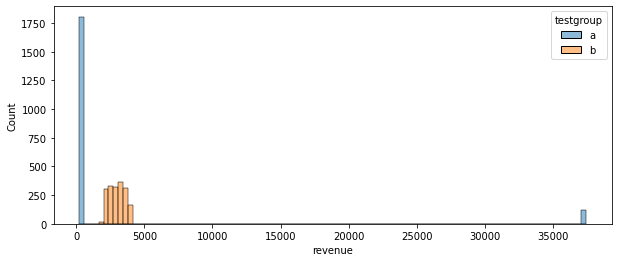

In [37]:
plt.figure(figsize=(10, 4))
sns.histplot(x = 'revenue', data = AB.query('revenue != 0'), hue = 'testgroup')

Из графика видно, что распределение ни в одной из групп не является нормальным. 
\
Помимо этого в контрольной группе можно выделить две подгруппы - заплативших очень мало и, наоборот, очень много.
\
В тестовой группе все пользователи платят менее 5000, а в контрольной отдельной группой можно выделить группу пользователей (123 человека (6.4 %)), вклад от которой в доход составялет практически 90 %:

In [38]:
a1 = a.query('revenue > 5000').user_id.count()

In [39]:
a1

123

In [40]:
a11 = a.user_id.count()

In [41]:
a1 / a11 * 100

6.379668049792531

In [42]:
a111 = round(a.query('revenue > 5000').revenue.sum() / a.revenue.sum() * 100, 2)

In [43]:
a111

89.37

Уже из графика выше видно, что распределения для обеих групп не являются нормальным. Однако, для полного удостоверения в этом проведем normaltest и построим qqplot.

In [44]:
stats.normaltest(a.revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [45]:
stats.normaltest(b.revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

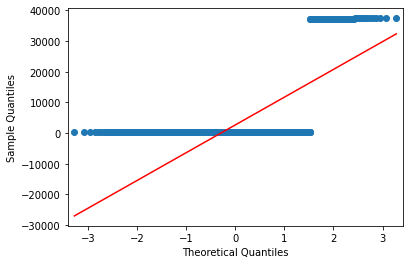

In [46]:
sm.qqplot(a.revenue, line = 's')
pylab.show()

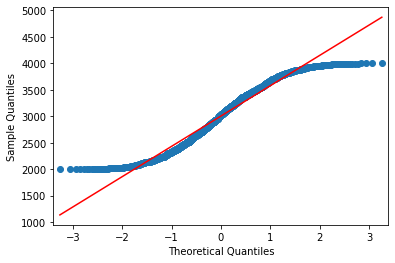

In [47]:
sm.qqplot(b.revenue, line = 's')
pylab.show()

Чтд по поводу ненормальности распределений.

Проверим гомогенность дисперсий наших выборок с помощью критерия Левена.

In [48]:
stats.levene(a.revenue, b.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Видим, что p-value < 0.05 -> Отклоняем нулевую гипотезу о равенстве дисперсий.

Таким образом, исходя из ненормальности распределений и негомогенности дисперсий - применение t-теста в данном случае нецелесообразно.
\
\
Применим непараметрический критерий Манна-Уитни, который менее чувствителен к экстремальным отклонениям от нормальности (а в нашем случае распределения как раз ненормальны, и присутствует значительная группа пользователей, которые платят значительно болше остальных в подвыборке).
\
\
Сначала применим для групп целиком, а потом только для платящих пользователей.

In [49]:
scipy.stats.mannwhitneyu(AB[AB.testgroup == "a"].revenue, AB[AB.testgroup == "b"].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

p-value > 0.05, то есть отвергнуть нулевую гипотезу об отсутствии разницы между выборками мы не можем. Статистических различий нет.

In [50]:
scipy.stats.mannwhitneyu(a.revenue, b.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

p-value < 0.05, выборки отличаются. Статистические различия значимы между ARPPU (собственно метрика о платящих пользователях).
\
В данном случае какие-то еще выводы мы сделать не можем на основании теста Манна-Уитни.

Также применим для сравнения наших групп метод bootstrap.

In [51]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа 
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Применим bootstrap (расчет через среднее значение) для наших изначальных двух групп. Построим гистограмму, а также рассчитаем p-value

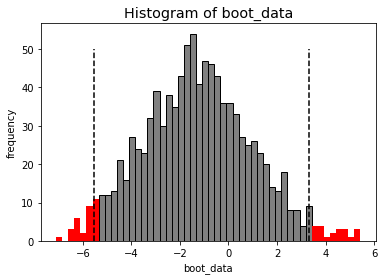

In [52]:
booted_data_mean_ARPU = get_bootstrap(AB[AB.testgroup == "a"].revenue, 
                                 AB[AB.testgroup == "b"].revenue, 
                                 boot_it = 1000,
                                 statistic = np.mean)

In [53]:
booted_data_mean_ARPU["p_value"] 

0.5655645689527997

Из полученного графика видно, что 0 попадает в доверительный интервал, то есть статистической разницы по ARPU мы не выявили.
\
Также и по p-value, которое > 0.05, можно сказать об отсутствии статистически значимых различий ARPU между группами.

Как и в случае критерия Манна-Уитни, применим бутстрап для исследования ARPPU (платящих пользователей).

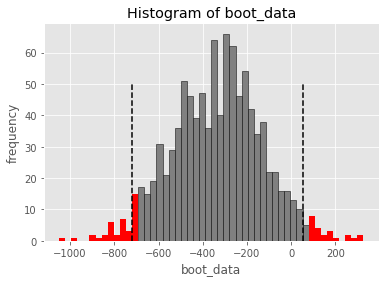

In [54]:
booted_data_mean_ARPPU = get_bootstrap(a.revenue, 
                                 b.revenue, 
                                 boot_it = 1000,
                                 statistic = np.mean)

In [55]:
booted_data_mean_ARPPU["p_value"] 

0.1010407247560025

Как и в случае с ARPU на графике 0 попадает в доверительный интервал, то есть статистической разницы по ARPPU также нет.
\
Как и по p-value, которое болше 0.05

Таким образом, при рассмотрении бутстрапа для среднего можно сказать о том, что статистической разницы между группами ни для ARPU, ни для ARPPU нет.
\
Однако, если применить бутстрап к медианным значениям для ARPPU, то получим следующее:

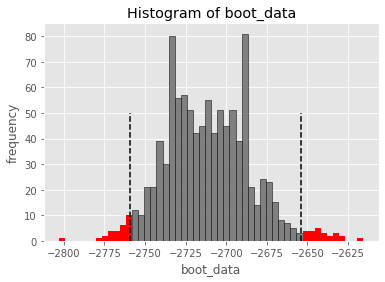

In [56]:
booted_data_median_ARPPU = get_bootstrap(a.revenue, 
                                 b.revenue, 
                                 boot_it = 1000,
                                 statistic = np.median)

In [57]:
booted_data_median_ARPPU["p_value"] 

0.0

С точки зрения медианных значений мы должны отклонить нулевую гипотезу, однако следует помнить о наличии подгруппы с серьезными тратами. Вклад от этих пользователей сильно влияет на средние значения.

 
 
## Выводы:

Стоит сразу сказать, что распределения в наших подгруппах носят значительно разный характер. В тестовой группе, пусть распределение и не является нормальным, все пользователи платят в пределх 2 - 4 тысяч. В контрольной же группе более 90 % пользователей платят очень маленькие суммы, а небольшая подгруппа огромные суммы, при этом вклад от которых составялет почти 90 %.
\
\
С точки зрения проведенного A/B-тестирования разницы в выручке между контрольной и тестовой группой мы не видим.
\
\
Остается вопрос - какой вариант лучше?
Все зависит от настроя и желания фирмы.
Можно держаться практически за всех пользователей, и они будут платить "средние" сумма - тогда набор предложений, возможных акций от фирмы будет один.
\
\
Можно пойти по другому пути и больше внимания уделять многоплатящим пользователям - другой набор акций и предложений.
\
\
На свое усмотрение я бы предпочел ПЕРВЫЙ вариант. Как основной момент такого выбора - в случае потери даже нескольких пользователей во втором варианте - велика вероятность высокой потери прибыли, если эти пользователи окажутся из подгруппы многоплатящих.





## Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## Первый случай

1. DAU, WAU, MAU - количество уникальных пользователей за сутки/неделю/месяц. Можно сравнить количество пользователей в дни с тематическими событиями и в обычные дни.


2. Stickiness - сравнить "липкость" в обычные дни и в дни с ивентами.


3. Session и ASD — время, проведенное пользователем в мобильном приложении/среднее время сессий за период времени.


4. CR - можно оценить влияние ивента на данные показатель


5. ARPU и ARPPU - можно оценить влияние ивента (например, будет ли пользователь становиться платящим, чтобы проходить трудные задания с целью получить лучшие награды).


6. Retention - можно посмотреть, будут ли пользователи чаще заходить в игру после проведения ивента.

## Второй случай

Помимо метрик из первого случая также можно добавить следующие:

1. Посмотреть ОТКАТ пользователей после неудачной попытки (одной, двух, трех и т.д.).


2. Выяснить УРОВНИ, на которыз чаще всего происходят откаты.


3. Найти "ТОЧКУ НЕВОЗВРАТА" - среднее число откатов на пользователя - после какого количества неудачных попыток пользователь перестает заходить в игру.